[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LorenzoRimella/epidemiology_workshop/blob/main/UP_Diliman/inference.ipynb)

Import everything from previous notebook

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep
import time
import scipy.stats as stats
from scipy import stats
import scipy

import numpy as np

gaussian = stats.norm

In [3]:
def SIR_step_0(N, p_0, n_simulation = 1): # shape is the

    X_0 = tfp.distributions.Multinomial(total_count = N, probs = p_0)

    return X_0.sample((n_simulation))

In [4]:
def K_SIR(beta, gamma, x):

    N = tf.reduce_sum(x, axis = -1)

    prob_SI = 1 - tf.math.exp(-tf.einsum("p,sp->sp", beta, x[...,1]/N))
    prob_IR = 1 - tf.math.exp(-tf.einsum("p,sp->sp", gamma, tf.ones(tf.shape(x[...,1]))))

    prob_SI = tf.expand_dims(prob_SI, axis = -1)
    prob_IR = tf.expand_dims(prob_IR, axis = -1)

    K_x_row_1 = tf.concat((             1 -  prob_SI  ,                   prob_SI  , tf.zeros(tf.shape(prob_SI)) ), axis = -1)
    K_x_row_2 = tf.concat((tf.zeros(tf.shape(prob_SI)),               1 - prob_IR  ,                   prob_IR   ), axis = -1)
    K_x_row_3 = tf.concat((tf.zeros(tf.shape(prob_SI)), tf.zeros(tf.shape(prob_SI)),  tf.ones(tf.shape(prob_SI)) ), axis = -1)

    return tf.stack((K_x_row_1, K_x_row_2, K_x_row_3), axis = -2)

In [5]:
def SIR_step_t(beta, gamma, x_tm1):

    K_tm1 = K_SIR(beta, gamma, x_tm1)

    multinomial_kernel = tfp.distributions.Multinomial(x_tm1, probs = K_tm1)

    Z_tm1_t = multinomial_kernel.sample()

    return tf.reduce_sum(Z_tm1_t, axis = -2)

In [6]:
def SIR_observe_t(q, x_t):

    q_expanded = tf.einsum("spi,pi->spi", tf.ones(tf.shape(x_t)), q  )

    emission_distribution = tfp.distributions.Binomial(x_t, probs = q_expanded)

    return emission_distribution.sample()

In [7]:
@tf.function(jit_compile=True)
def compartmental_model_simulation(p_0, beta, gamma,
                                   q,
                                   T = 100, n_simulations = 1):

    x_0 = SIR_step_0(N, p_0, n_simulations)
    y_0 = -10*tf.ones(tf.shape(x_0))

    def body(input, t):

        x_tm1, _ = input

        x_t = SIR_step_t(beta, gamma, x_tm1)
        y_t = SIR_observe_t(q, x_t)

        return x_t, y_t

    X, Y = tf.scan(body, tf.range(0, T), initializer = (x_0, y_0))

    return tf.concat((tf.expand_dims(x_0, axis = 0), X), axis = 0), Y

# Simulate the data

In [8]:
N = 10000 # population of 1000 individuals
p_0 = tf.convert_to_tensor([[0.99, 0.01, 0.0]], dtype = tf.float32) # we have a parameter dimension

beta  = tf.convert_to_tensor([0.2], dtype = tf.float32) # again a parameters dimension
gamma = tf.convert_to_tensor([0.1], dtype = tf.float32) # again a parameters dimension

q = tf.convert_to_tensor([[0.0, 0.1, 0.0]], dtype = tf.float32) # we have again a parameter dimension

T = 200

X, Y =  compartmental_model_simulation(p_0, beta, gamma, q, T, 1)


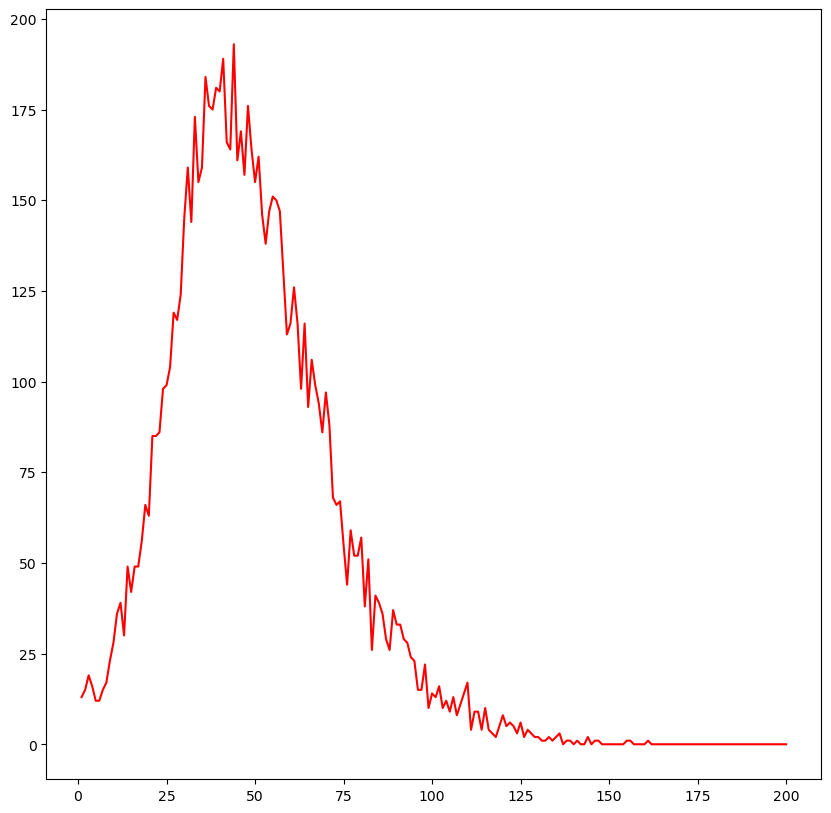

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

time_steps = np.linspace(0, 200, 201)

ax.plot(time_steps[1:], Y[:,0,0,1], color = "red")

# Sequential Monte Carlo

The intial step is to produce the initial particles

In [10]:
n_particles = 1000

xp_0 = SIR_step_0(N, p_0, n_particles)
logwp_0 = tf.zeros(tf.shape(xp_0)[:-1])

Then we want to resample according to the weights

In [11]:
logwp_tm1 = logwp_0
xp_tm1 = xp_0

res_prob = tf.math.exp(logwp_tm1 - tf.reduce_max(logwp_tm1, axis = 0, keepdims=True))/tf.reduce_sum(tf.math.exp(logwp_tm1 - tf.reduce_max(logwp_tm1, axis = 0, keepdims=True)), axis = 0, keepdims=True)

indeces = tfp.distributions.Categorical(probs=tf.transpose(res_prob)).sample(n_particles)

resxp_tm1 = tf.gather(xp_tm1, indeces[:,0], axis = 0)

In [12]:
def resampling(logwp_tm1, xp_tm1):

    res_prob = tf.math.exp(logwp_tm1 - tf.reduce_max(logwp_tm1, axis = 0, keepdims=True))/tf.reduce_sum(tf.math.exp(logwp_tm1 - tf.reduce_max(logwp_tm1, axis = 0, keepdims=True)), axis = 0, keepdims=True)

    indeces = tfp.distributions.Categorical(probs=tf.transpose(res_prob)).sample(n_particles)

    resxp_tm1 = tf.gather(xp_tm1, indeces[:,0], axis = 0)

    return resxp_tm1

Now we want to propagate

In [13]:
xp_t = SIR_step_t(beta, gamma, resxp_tm1)

def propagate(beta, gamma, resxp_tm1):

    return SIR_step_t(beta, gamma, resxp_tm1)

And reweight

In [14]:
q_expanded = tf.einsum("spi,pi->spi", tf.ones(tf.shape(xp_t)), q  )

emission_distribution = tfp.distributions.Binomial(xp_t, probs = q_expanded)

logwp_t = tf.reduce_sum(emission_distribution.log_prob(Y[0,...]), axis =-1)

def reweighting(q, xp_t, y_t):
    q_expanded = tf.einsum("spi,pi->spi", tf.ones(tf.shape(xp_t)), q  )

    emission_distribution = tfp.distributions.Binomial(xp_t, probs = q_expanded)

    return tf.reduce_sum(emission_distribution.log_prob(y_t), axis =-1)

We can then put everything together and get

In [15]:
@tf.function(jit_compile=True)
def BPF(p_0, beta, gamma, q, Y, n_particles = 1000):

    xp_0 = SIR_step_0(N, p_0, n_particles)
    logwp_0 = tf.zeros(tf.shape(xp_0)[:-1])

    def body(input, t):

        logwp_tm1, xp_tm1 = input

        resxp_tm1 = resampling(logwp_tm1, xp_tm1)
        xp_t      = propagate(beta, gamma, resxp_tm1)

        y_t  = Y[t,...]
        logwp_t = reweighting(q, xp_t, y_t)

        return logwp_t, xp_t

    logWp, Xp = tf.scan(body, tf.range(0, T), initializer = (logwp_0, xp_0))

    return logWp, tf.concat((tf.expand_dims(xp_0, axis = 0), Xp), axis = 0)

In [16]:
 logWp, Xp = BPF(p_0, beta, gamma, q, Y, n_particles)

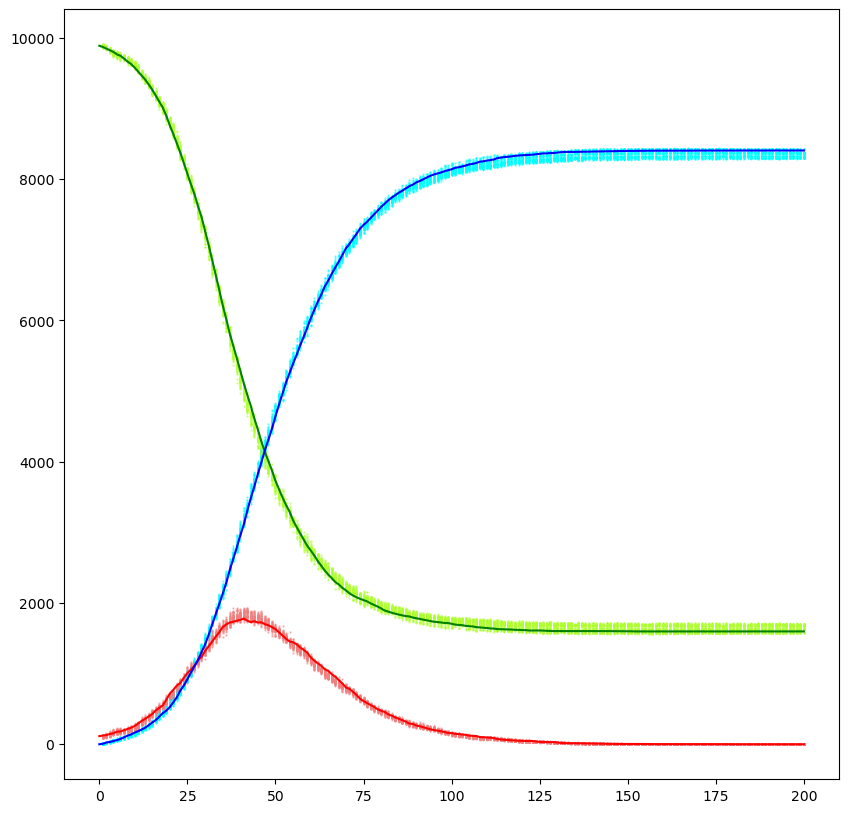

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

time_steps = np.linspace(0, 200, 201)

ax.plot(time_steps, X[:,0,0,0], color = "green")
ax.plot(time_steps, X[:,0,0,1], color = "red")
ax.plot(time_steps, X[:,0,0,2], color = "blue")

for i in range(500, 550):
    ax.scatter(time_steps[1:], Xp[1:,i,0,0], alpha = 0.5, s = 0.5, color = "greenyellow")
    ax.scatter(time_steps[1:], Xp[1:,i,0,1], alpha = 0.5, s = 0.5, color = "lightcoral")
    ax.scatter(time_steps[1:], Xp[1:,i,0,2], alpha = 0.5, s = 0.5, color = "cyan")

And of course we can also compute the likelihood!

In [18]:
log_likelihood = tf.reduce_sum(tf.math.log(tf.reduce_mean(tf.math.exp(logWp - tf.reduce_max(logWp, axis = 1, keepdims = True)), axis =1)) + tf.reduce_max(logWp, axis = 1))

We can use a black-box optimiser from the library scipy to compute $\beta$

In [19]:
def to_optimise(log_beta_numpy): 

    beta  = tf.convert_to_tensor(np.exp(-log_beta_numpy), dtype = tf.float32)

    logWp, _ = BPF(p_0, beta, gamma, q, Y, n_particles)

    log_likelihood = tf.reduce_sum(tf.math.log(tf.reduce_mean(tf.math.exp(logWp - tf.reduce_max(logWp, axis = 1, keepdims = True)), axis =1)) + tf.reduce_max(logWp, axis = 1))

    return -log_likelihood.numpy()

In [20]:
from scipy.optimize import minimize

bnds = ((0., 3.),)

x_0 = np.array([np.random.uniform(bnds[0][0],bnds[0][1])])
res = minimize(to_optimise, x_0, bounds = bnds, method='SLSQP', options ={"eps":0.5, "maxiter":100})

print("Our estimate of 0.2 is ", np.exp(-res.x)[0])

Our estimate of 0.2 is  0.22697588202912763


# Approximate Bayesian Computation

Suppose that we wanna learn $\beta$, we can propose different $\beta$'s according to a uniform distribution and accept/reject if the simulated epidemic is "close" to the observed epidemic.

We can create a sample of size $1000$ and simulate $100$ epidemics, then we can compute the mean euclidean distance and accept according to a threshold:
- $\beta^p  \sim U(low, high)$;
- $y_{1:T}^{p,s} \sim  p(Y_{1:T}|\beta^p)$;
- $M_p = \frac{1}{S}\sum_s \sqrt{\sum_t (y_t^{p,s}-y_t)^2}$;
- if $M_p<threshold$ keep $\beta^p$ otherwise reject.

In [21]:
ABC_parallel_sample = 500
p_0_ABC = tf.convert_to_tensor([[0.99, 0.01, 0.0]], dtype = tf.float32)*tf.ones((ABC_parallel_sample, 1))

beta_ABC  = tfp.distributions.Uniform(low=0.01, high=1.0).sample((ABC_parallel_sample))
gamma_ABC = tf.convert_to_tensor(0.1, dtype = tf.float32)*tf.ones((ABC_parallel_sample))

q_ABC = tf.convert_to_tensor([[0.0, 0.1, 0.0]], dtype = tf.float32)*tf.ones((ABC_parallel_sample, 1))

T = 200

_, Y_ABC =  compartmental_model_simulation(p_0_ABC, beta_ABC, gamma_ABC, q_ABC, T, 50)


Now compute the metric for accept/reject.

In [22]:
print("The dimensions of Y_ABC are ", tf.shape(Y_ABC))
print("The dimensions of Y are ", tf.shape(Y))

Metric = tf.reduce_mean(tf.math.sqrt(tf.reduce_sum(tf.math.pow((Y_ABC[...,1] - Y[...,1]), 2), axis = 0)), axis = 0)

The dimensions of Y_ABC are  tf.Tensor([200  50 500   3], shape=(4,), dtype=int32)
The dimensions of Y are  tf.Tensor([200   1   1   3], shape=(4,), dtype=int32)


Reject according to a threshold

In [23]:
threshold = 2000

indeces = tf.where(Metric<threshold)
beta_sample = tf.gather(beta_ABC, indeces)

Do a KDE and plot.

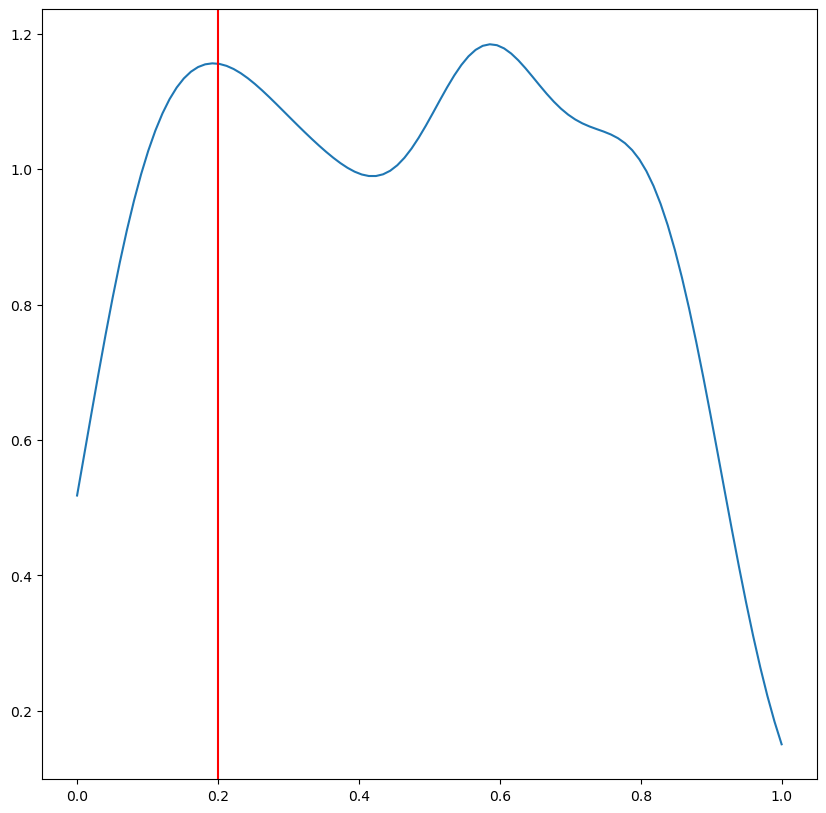

In [24]:
kernel = scipy.stats.gaussian_kde(beta_sample[:,0].numpy())

beta_grid = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.plot(beta_grid, kernel(beta_grid))
ax.axvline(x = beta.numpy(), color = "red")

Note that we have again a pipeline to do an ABC iteration that we can collect in a function

In [25]:
def ABC_beta_step(Y, threshold, low_beta_prior, high_beta_prior, ABC_parallel_sample = 500, parallel_simulations = 50):

    T = tf.shape(Y)[0]

    p_0_ABC = tf.convert_to_tensor([[0.99, 0.01, 0.0]], dtype = tf.float32)*tf.ones((ABC_parallel_sample, 1))

    beta_ABC  = tfp.distributions.Uniform(low=low_beta_prior, high=high_beta_prior).sample((ABC_parallel_sample))
    gamma_ABC = tf.convert_to_tensor(0.1, dtype = tf.float32)*tf.ones((ABC_parallel_sample))

    q_ABC = tf.convert_to_tensor([[0.0, 0.1, 0.0]], dtype = tf.float32)*tf.ones((ABC_parallel_sample, 1))

    _, Y_ABC = compartmental_model_simulation(p_0_ABC, beta_ABC, gamma_ABC, q_ABC, T, parallel_simulations)

    Metric = tf.reduce_mean(tf.math.sqrt(tf.reduce_sum(tf.math.pow((Y_ABC[...,1] - Y[...,1]), 2), axis = 0)), axis = 0)

    indeces = tf.where(Metric<threshold)
    beta_sample = tf.gather(beta_ABC, indeces)

    return beta_sample

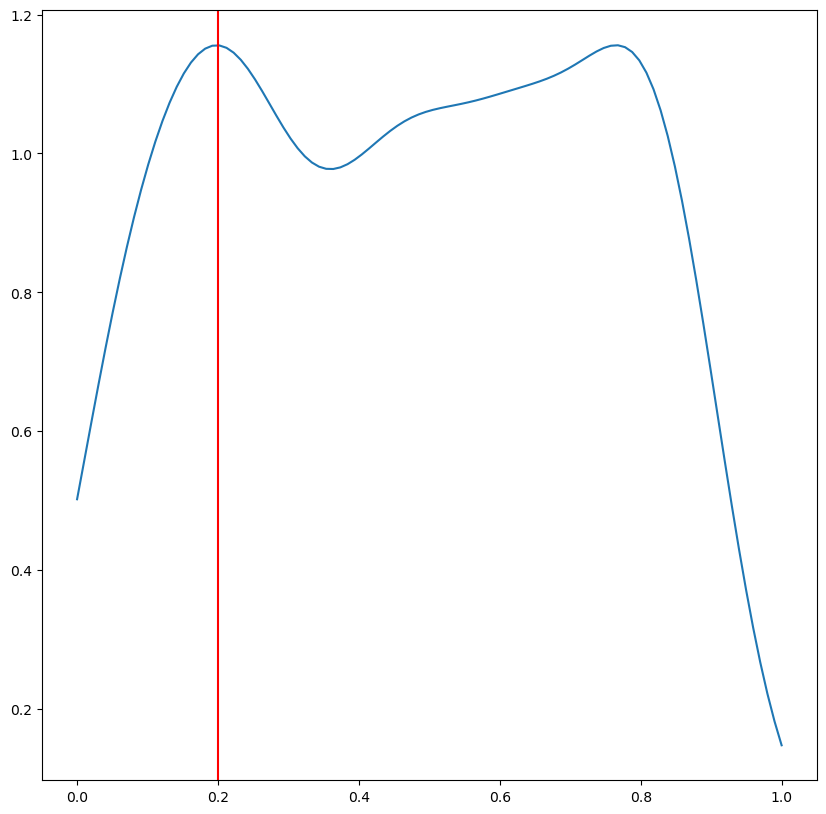

In [26]:
threshold = 2000
low_beta_prior = 0.01
high_beta_prior = 0.99

beta_sample = ABC_beta_step(Y, threshold, low_beta_prior, high_beta_prior)

kernel = scipy.stats.gaussian_kde(beta_sample[:,0].numpy())
beta_grid = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.plot(beta_grid, kernel(beta_grid))
ax.axvline(x = beta.numpy(), color = "red")

Note that we can recursively decrease the threshold and sampling range improve our estimate.

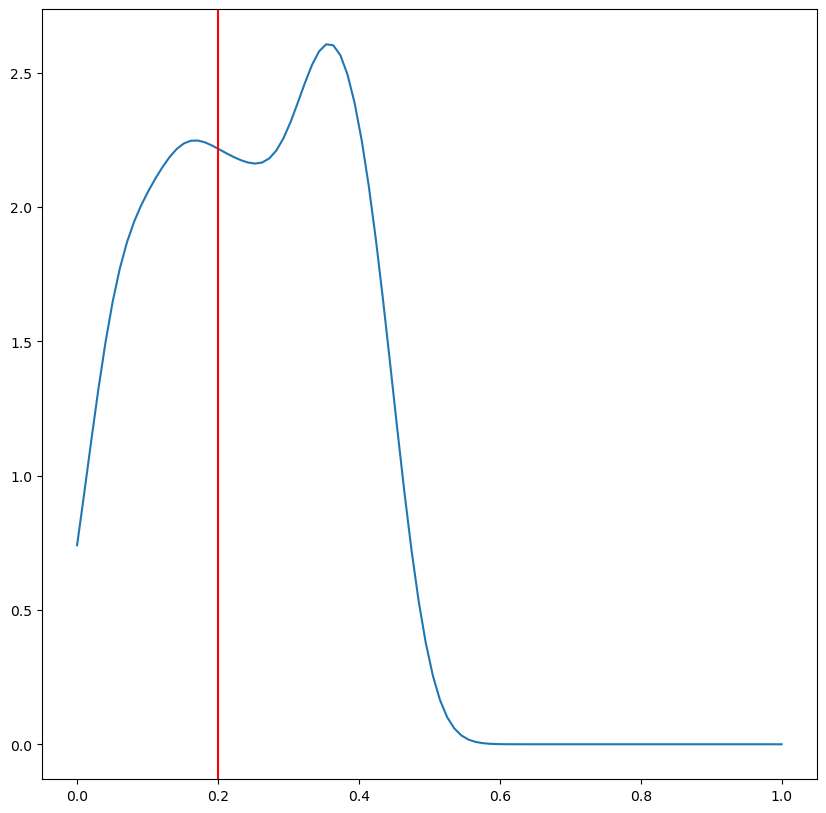

In [27]:
threshold = threshold*0.75
low_beta_prior = tf.reduce_min(beta_sample)
high_beta_prior = tf.reduce_max(beta_sample)

beta_sample = ABC_beta_step(Y, threshold, low_beta_prior, high_beta_prior, ABC_parallel_sample)

kernel = scipy.stats.gaussian_kde(beta_sample[:,0].numpy())
beta_grid = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.plot(beta_grid, kernel(beta_grid))
ax.axvline(x = beta.numpy(), color = "red")

We can then iteratively decrease our sampling space and threshold and see what happens...

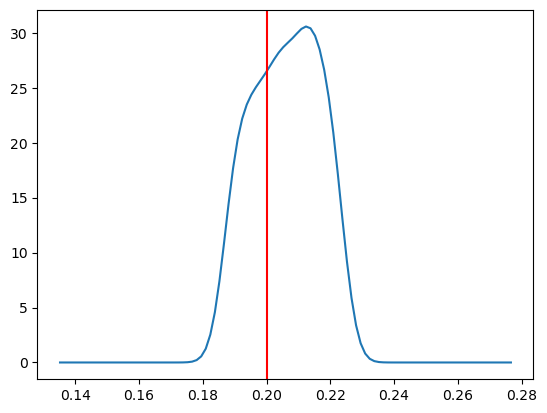

In [28]:
threshold = 2000
low_beta_prior = 0.01
high_beta_prior = 0.99

beta_sample = ABC_beta_step(Y, threshold, low_beta_prior, high_beta_prior)

kernel = scipy.stats.gaussian_kde(beta_sample[:,0].numpy())
beta_grid = np.linspace(0, 1, 100)

plt.plot(beta_grid, kernel(beta_grid))
plt.axvline(x = beta.numpy(), color = "red")

plt.show()

for i in range(20):

  clear_output(wait=True)

  threshold = threshold*0.9
  if threshold<50:
    threshold = 50

  low_beta_prior = tf.reduce_max([tf.reduce_min(beta_sample)-0.05, 0.0])
  high_beta_prior = tf.reduce_max(beta_sample)+0.05

  beta_sample = ABC_beta_step(Y, threshold, low_beta_prior, high_beta_prior)

  kernel = scipy.stats.gaussian_kde(beta_sample[:,0].numpy())
  beta_grid = np.linspace(low_beta_prior, high_beta_prior, 100)

  plt.plot(beta_grid, kernel(beta_grid))
  plt.axvline(x = beta.numpy(), color = "red")

  plt.show()

In [29]:
print("The final threshold used is ", np.round(threshold,2))

The final threshold used is  243.15


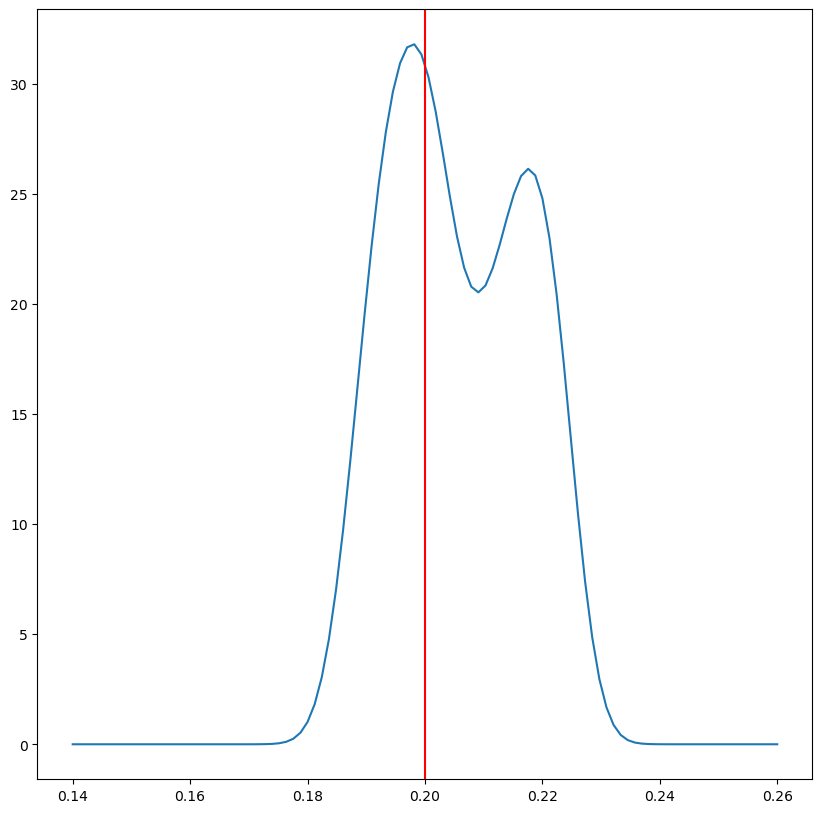

In [30]:
threshold = 250
low_beta_prior = 0.14
high_beta_prior = 0.26

beta_sample = ABC_beta_step(Y, threshold, low_beta_prior, high_beta_prior)

kernel = scipy.stats.gaussian_kde(beta_sample[:,0].numpy())
beta_grid = np.linspace(low_beta_prior, high_beta_prior, 100)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.plot(beta_grid, kernel(beta_grid))
ax.axvline(x = beta.numpy(), color = "red")